<a href="https://colab.research.google.com/github/jsscmaina/machinelearning4102/blob/master/CAT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model,metrics
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV

# from sklearn.preprocessing import Imputer # class to handle missing values
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded=files.upload()

Saving housing.csv to housing.csv


In [4]:
housing=pd.read_csv('housing.csv', header=0)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


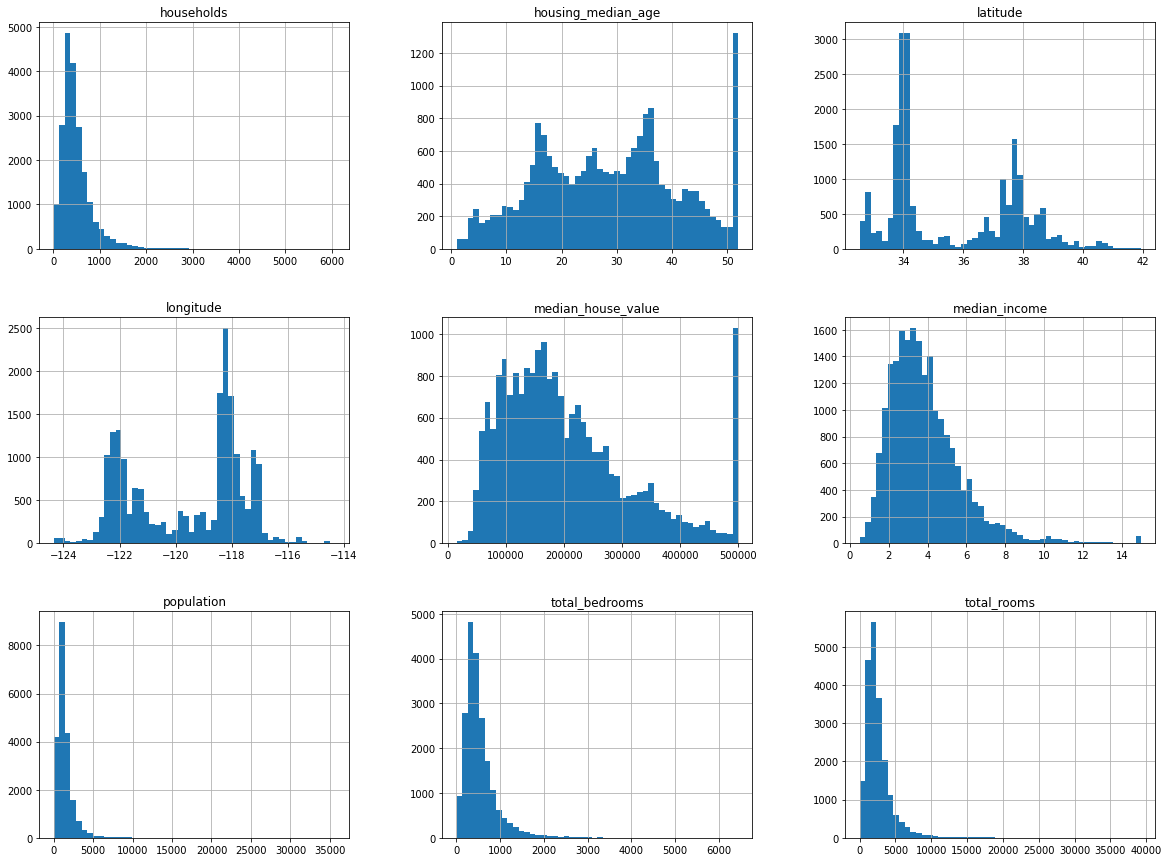

In [5]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Data Processing

In [6]:
df = housing.copy()
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# statistical description of missing values column
df['total_bedrooms'].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

<function matplotlib.pyplot.plot>

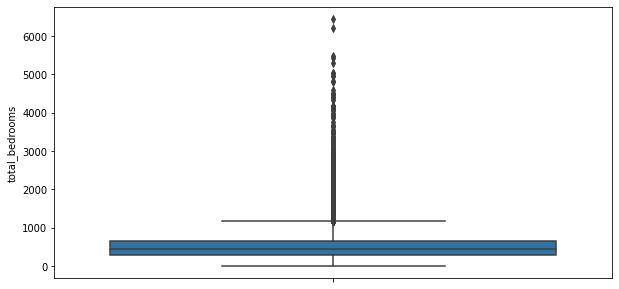

In [8]:
# boxplot on total_bedrooms
plt.figure(figsize=(10,5))
sns.boxplot(y='total_bedrooms',data=df)
plt.plot

In [9]:
'''
Filling the missing values of total_bedrooms based upon categories of ocean_proximity
'''
imputer = SimpleImputer(strategy='median')
housing_num = df.drop('ocean_proximity', axis=1) # convert to numerical
imputer.fit(housing_num)
# imputer.statistics_
housing_num.median().values


array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [10]:
X = imputer.transform(housing_num)
# X
housing_tr = pd.DataFrame(X, columns=housing_num.columns)# converting the numpy array back to a DataFrame
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [11]:
housing_tr.isnull().sum() # Now there are no missing values

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [12]:
len(housing_tr)

20640

Feature Selection

median_housing_value is the target

In [13]:
pre_data = housing.drop(columns=['median_house_value'],axis=1)
all_features = list(pre_data.columns)
len(all_features)

9

In [14]:
categorical_data=housing.select_dtypes(include=['object']).copy()
categorical_features=list(categorical_data.columns)
#categorical_data.head()
categorical_features

['ocean_proximity']

In [15]:
nominal=['ocean_proximity']
ordinal=list(set(categorical_features)-set(nominal))
numerical=list(set(all_features)-set(categorical_features))
target=['median_house_value']

for feature in categorical_features:
  categorical_data[feature]=categorical_data[feature].astype('category')
for feature in ordinal:
  categorical_data[feature]=categorical_data[feature].cat.codes
categorical_data.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


Encoding

In [16]:
data_copy=categorical_data.copy()

data_copy = pd.concat([pd.get_dummies(data_copy[nominal]),data_copy],axis=1) 
data_copy.drop(nominal,axis=1,inplace=True)

new_data = pd.concat([data_copy,housing_tr[numerical],housing_tr[target]],axis=1)
new_data

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,longitude,median_income,total_rooms,housing_median_age,population,latitude,total_bedrooms,households,median_house_value
0,0,0,0,1,0,-122.23,8.3252,880.0,41.0,322.0,37.88,129.0,126.0,452600.0
1,0,0,0,1,0,-122.22,8.3014,7099.0,21.0,2401.0,37.86,1106.0,1138.0,358500.0
2,0,0,0,1,0,-122.24,7.2574,1467.0,52.0,496.0,37.85,190.0,177.0,352100.0
3,0,0,0,1,0,-122.25,5.6431,1274.0,52.0,558.0,37.85,235.0,219.0,341300.0
4,0,0,0,1,0,-122.25,3.8462,1627.0,52.0,565.0,37.85,280.0,259.0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0,1,0,0,0,-121.09,1.5603,1665.0,25.0,845.0,39.48,374.0,330.0,78100.0
20636,0,1,0,0,0,-121.21,2.5568,697.0,18.0,356.0,39.49,150.0,114.0,77100.0
20637,0,1,0,0,0,-121.22,1.7000,2254.0,17.0,1007.0,39.43,485.0,433.0,92300.0
20638,0,1,0,0,0,-121.32,1.8672,1860.0,18.0,741.0,39.43,409.0,349.0,84700.0


Feature Extraction & Dimensionality Reduction using PCA with 90% variance

In [17]:
all_features = list(new_data.columns)
# all_features
X = new_data.loc[:,all_features[0]:all_features[-2]].values
y = new_data.loc[:,[all_features[-1]]].values
y

array([[452600.],
       [358500.],
       [352100.],
       ...,
       [ 92300.],
       [ 84700.],
       [ 89400.]])

In [18]:
X = PowerTransformer().fit_transform(X)
y = PowerTransformer().fit_transform(y)
# X
y

array([[ 1.71807808],
       [ 1.26294108],
       [ 1.22831393],
       ...,
       [-1.13928351],
       [-1.2781533 ],
       [-1.19104913]])

In [19]:
pca_with_varia = PCA(0.9)
pca_with_varia.fit_transform(X)
pca_with_varia.n_components_

7

In [20]:
pca = PCA(n_components=2)
pc_s = pca.fit_transform(X)
pca_data = pd.DataFrame(pc_s,columns=['PC1','PC2'])
target_data = pd.DataFrame(y,columns=['median_house_value'])
final_data = pd.concat([pca_data,target_data],axis=1)
final_data

,PC1,PC2,median_house_value
0,-3.366110,1.673565,1.718078
1,2.657383,2.934477,1.262941
2,-2.627586,1.859894,1.228314
3,-2.441749,1.941577,1.168611
4,-2.142396,2.090290,1.173649
...,...,...,...
20635,-1.164049,1.975475,-1.407902
20636,-3.133140,1.491283,-1.428392
20637,-0.345797,2.157570,-1.139284
20638,-0.939459,2.046786,-1.278153


In [21]:
final_data.describe()

,PC1,PC2,median_house_value
count,2.064000e+04,2.064000e+04,2.064000e+04
mean,7.098112e-17,-1.390683e-15,-1.470142e-15
std,1.988788e+00,1.596331e+00,1.000024e+00
min,-8.984070e+00,-3.616911e+00,-3.780890e+00
25%,-1.142277e+00,-1.510814e+00,-7.114094e-01
50%,-9.092657e-02,-1.734452e-01,-1.052064e-02
75%,1.110838e+00,1.487522e+00,6.902740e-01
max,1.097759e+01,4.056506e+00,1.916642e+00


Data Distribution Examination



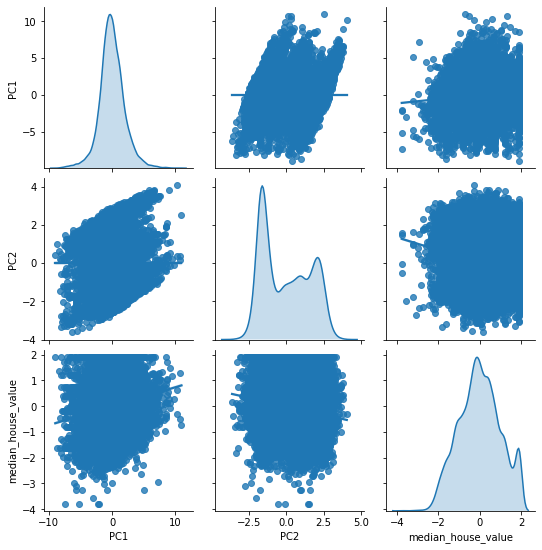

In [22]:
import seaborn as sns
sns.pairplot(final_data,kind='reg', diag_kind='kde')

In [23]:
final_data_array = final_data.to_numpy()
final_data_array

array([[-3.36610982,  1.67356455,  1.71807808],
       [ 2.65738265,  2.93447715,  1.26294108],
       [-2.6275863 ,  1.85989429,  1.22831393],
       ...,
       [-0.34579747,  2.15757048, -1.13928351],
       [-0.93945936,  2.04678603, -1.2781533 ],
       [ 0.40981658,  2.24767912, -1.19104913]])

In [30]:
all_features = list(final_data.columns)
all_features
X_2 = final_data.loc[:,all_features[0]:all_features[-2]].values
y_2 = final_data.loc[:,[all_features[-1]]].values

Model Selection

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_2,y_2,test_size=0.3,random_state=0)

In [32]:
# Normalising the Data
from sklearn.preprocessing import MinMaxScaler
ms=MinMaxScaler()
X_train=ms.fit_transform(X_train)
X_test=ms.transform(X_test)

In [33]:
# RMSE function
def evaluate(ypred,ytest,regressor):
    print("root mean squared error for test data   is "+str(np.sqrt(mean_squared_error(ytest,ypred))))

In [35]:
from sklearn.metrics import mean_squared_error

# Regressor Model
def regressor_model(x,y,estimator):
   
    regressor=estimator()
    regressor.fit(x,y)
    lr_rmse=np.sqrt(mean_squared_error(y,regressor.predict(x)))
    cv_regressor=cross_val_score(cv=10,X=x,y=y,estimator=regressor,scoring='r2')
    print('The cross validation accuracy is - '+str(100*cv_regressor.mean()))
    print('The cross validation variance is - '+str(100*cv_regressor.std()))
    return regressor

In [36]:
from sklearn.linear_model import LinearRegression

l=regressor_model(X_train,y_train,LinearRegression)
evaluate(l.predict(X_test),y_test,l)

The cross validation accuracy is - 6.167765997905099
The cross validation variance is - 1.585319927884244
root mean squared error for test data   is 0.9664874796026065


In [37]:
from sklearn.linear_model import Lasso

l=regressor_model(X_train,y_train,Lasso)
evaluate(l.predict(X_test),y_test,l)


The cross validation accuracy is - -0.13104822563485996
The cross validation variance is - 0.14698164026819374
root mean squared error for test data   is 1.0015387746410058


In [38]:
from sklearn.linear_model import Ridge

l=regressor_model(X_train,y_train,Ridge)
evaluate(l.predict(X_test),y_test,l)


The cross validation accuracy is - 6.168080856820992
The cross validation variance is - 1.5793181083778196
root mean squared error for test data   is 0.9665113513756698


In [39]:
from sklearn.linear_model import  ElasticNet

l=regressor_model(X_train,y_train,ElasticNet)
evaluate(l.predict(X_test),y_test,l)

The cross validation accuracy is - -0.13104822563485996
The cross validation variance is - 0.14698164026819374
root mean squared error for test data   is 1.0015387746410058


Hyperparameter Tuning 

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

dt=regressor_model(X_train,y_train,DecisionTreeRegressor)

# Data Splitting using GridSearchCV
params=[{
            
            'max_depth':[2,3,4,5,6,10,20,30,40,50,60,70,100],
            'min_samples_split':[2,3,4,7,10,12],
            'min_samples_leaf' :[1,3,5,10,15,20,25],
            'max_features':['sqrt','log2'],
            
        }
        ]

gc=GridSearchCV(dt,params,cv=10,scoring='r2',n_jobs=-1)# Performing a cross validation of 10 folds
gc.fit(X_train,y_train)
gc.best_estimator_ # Finding the best estimator learnt from our grid search model

'''
In the first row of params we are trying 13 combinations
In the second row of params we are trying 6 combinations
In the third row of params we are trying 7 combinations
So, in total, 26 combinations

'''

The cross validation accuracy is - -59.92307588469181
The cross validation variance is - 5.7011250346789675


'\nIn the first row of params we are trying 13 combinations\nIn the second row of params we are trying 6 combinations\nIn the third row of params we are trying 7 combinations\nSo, in total, 26 combinations\n\n'

In [41]:
gc.best_score_

0.12100063084407564

In [42]:
from sklearn.ensemble import RandomForestRegressor

rg=RandomForestRegressor(n_estimators=10)
rg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)